In [1]:
import sys
import tyssue
import random
import numpy as np
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline
import ipyvolume as ipv
from matplotlib import pyplot
from tyssue.solvers import QSSolver

from IPython.display import Image


from tyssue.topology import add_vert


from tyssue import config, Sheet, SheetGeometry, History, EventManager, PlanarGeometry
from tyssue import SheetGeometry as geom
from tyssue import PlanarGeometry as geom
from tyssue.draw.plt_draw import create_gif
from tyssue.draw.plt_draw import plot_forces
from tyssue.draw import sheet_view
from tyssue.dynamics import effectors, model_factory
from tyssue.dynamics import PlanarModel
from tyssue.dynamics import SheetModel as model
from tyssue.generation import three_faces_sheet
from tyssue.solvers.viscous import EulerSolver
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
from tyssue.draw.plt_draw import plot_forces
from tyssue.io import hdf5
import copy

from tyssue.geometry.planar_geometry import PlanarGeometry as geom
from tyssue.solvers.quasistatic import QSSolver
from tyssue.dynamics.planar_vertex_model import PlanarModel as model


from tyssue.stores import load_datasets

from tyssue.topology.sheet_topology import remove_face, cell_division

import warnings
warnings.filterwarnings('ignore')

### T1 transitions

from tyssue.topology.sheet_topology import type1_transition
from tyssue.topology.base_topology import collapse_edge, remove_face
from tyssue.topology.sheet_topology import split_vert as sheet_split
from tyssue.topology.bulk_topology import split_vert as bulk_split
from tyssue.topology import condition_4i, condition_4ii

collision solver could not be imported You may need to install CGAL and re-install tyssue
C++ extension are not available for this version


In [2]:
def length_elasticity_range(cellmap, FRC_lower_length_elasticity, FRC_higher_length_elasticity, ECM_lower_length_elasticity, ECM_higher_length_elasticity):
    
    cellmap.edge_df['length_elasticity_ECM'] = cellmap.edge_df['length_elasticity']
    cellmap.edge_df['length_elasticity_FRC'] = cellmap.edge_df['length_elasticity']
        
    for edge in range(len(cellmap.edge_df)):
        FRC = random.randrange(FRC_lower_length_elasticity, FRC_higher_length_elasticity)/10000
        ECM = random.randrange(ECM_lower_length_elasticity, ECM_higher_length_elasticity)/10000
        cellmap.edge_df['length_elasticity'][edge] = FRC + ECM
        cellmap.edge_df['length_elasticity_ECM'][edge] = ECM
        cellmap.edge_df['length_elasticity_FRC'][edge] = FRC
    return cellmap

In [3]:
def prefered_area_range(cellmap, lower_prefered_area, higher_prefered_area):
    for face in range(len(cellmap.face_df)):
        newValue = random.randrange(lower_prefered_area, higher_prefered_area)/10000
        cellmap.face_df['prefered_area'][face] = newValue
    return cellmap

In [4]:
def change_specs(cellmap, geom, model, history, area_elasticity,
                 lower_prefered_area, higher_prefered_area, FRC_lower_length_elasticity, FRC_higher_length_elasticity, ECM_lower_length_elasticity,
                 ECM_higher_length_elasticity, line_nought):
    
    
    length_elasticity_range(cellmap, FRC_lower_length_elasticity, FRC_higher_length_elasticity, ECM_lower_length_elasticity, ECM_higher_length_elasticity)
    prefered_area_range(cellmap, lower_prefered_area, higher_prefered_area)
    
    cellmap.face_df["area_elasticity"] = area_elasticity
    cellmap.edge_df["prefered_length"] = line_nought


    cellmap.vert_df["viscosity"] = 1 
    
    geom.update_all(cellmap)
    
    
    #for i in range(endTime):
    #    solver = QSSolver()
    #    res = solver.find_energy_min(cellmap, geom, model)
    #    geom.update_all(cellmap)
    #   history.record(time_stamp=i)
    
    solver = QSSolver()
    res = solver.find_energy_min(cellmap, geom, model)

    fig, ax = sheet_view(cellmap, mode="quick")
    fig.set_size_inches(10, 10)
    
    cellmap_new = copy.deepcopy(cellmap)
    geom_new = copy.deepcopy(geom)
    model_new = copy.deepcopy(model)
    history_new = copy.deepcopy(history)
    
    return [cellmap_new, geom_new, model_new, history_new]

In [ ]:
## Definition of the sheet

cellmap_original = Sheet.planar_sheet_2d('cellmap', 30, 30, 1, 1, noise = 0.2) # This may need to change
geom_original  = PlanarGeometry

to_cut = cellmap_original.cut_out([(0, 20), (0, 20)])
cellmap_original.remove(to_cut, trim_borders=True)


geom.update_all(cellmap_original)
cellmap_original.update_rank()

model_original = model_factory([    
    effectors.FaceAreaElasticity,
    effectors.LengthElasticity
    ])

history_original = History(cellmap_original,
                           extra_cols={"edge":["dx", "dy"]})

cellmap_original.update_specs(model_original.specs)

fig, ax = sheet_view(cellmap_original, ['x', 'y'], mode='quick')

## Homeostasis

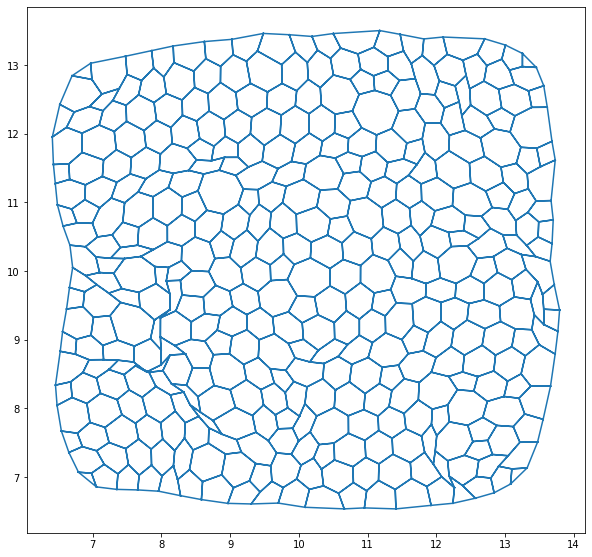

In [6]:
[cellmap_H, geom_H, model_H, history_H] = change_specs(cellmap_original, geom_original, model_original, history_original, area_elasticity = 0.5, lower_prefered_area = 100, higher_prefered_area = 10000, 
                                                       FRC_lower_length_elasticity = 100, FRC_higher_length_elasticity = 10000, ECM_lower_length_elasticity = 100, 
                                                       ECM_higher_length_elasticity = 10000, line_nought = 0.2)

In [7]:
mean_area_H = cellmap_H.face_df["prefered_area"].mean()
mean_area_H

0.5177460227272728

## Uniform Expansion

In [8]:
endTime = 20

current_prefered_area = cellmap_H.face_df['prefered_area']
cellmap_H.update_specs(
{"face": {"prefered_area": 3*current_prefered_area + 2*mean_area_H}},
reset=True)

current_FRC_length_elasticity = cellmap_H.edge_df['length_elasticity_FRC']
cellmap_H.update_specs(
{"edge": {"length_elasticity_FRC": 0.1*current_FRC_length_elasticity}},
reset=True)

current_line_nought = cellmap_H.edge_df['prefered_length']
cellmap_H.update_specs(
{"edge": {"prefered_length": 1.4*current_line_nought}},
reset=True)

new_verts = np.empty((0, 3))
for numEdge in range(len(cellmap_H.edge_df)):
    currentEdge = cellmap_H.edge_df.loc[numEdge];
    if currentEdge['length']>2:
        new_vert = add_vert(cellmap_H, numEdge)
        new_verts = np.append(new_verts, [new_vert])
        
        for i in range(endTime):
            solver = QSSolver()
            res = solver.find_energy_min(cellmap_E, geom_E, model_E, options={"ftol": 1e-2})
            geom_H.update_all(cellmap_E)
            history_H.record(time_stamp = i)


        
        #solver = QSSolver()
        #res = solver.find_energy_min(cellmap_H, geom_H, model_H)
    
    
cellmap_E = copy.deepcopy(cellmap_H)
geom_E = copy.deepcopy(geom_H)
model_E = copy.deepcopy(model_H)
history_E = copy.deepcopy(history_H)





Reseting column prefered_area of the face dataset with new specs
Reseting column length_elasticity_FRC of the edge dataset with new specs
Reseting column prefered_length of the edge dataset with new specs


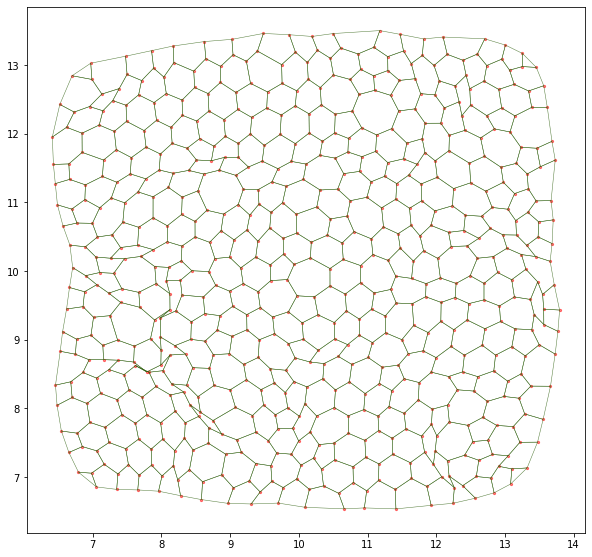

In [9]:
draw_specs = tyssue.config.draw.sheet_spec()

draw_specs['vert']['visible'] = True

draw_specs['vert']['color'] = "red"
draw_specs['vert']['alpha'] = 0.5
draw_specs['vert']['s'] = 5
coords = ['x', 'y']
fig, ax = sheet_view(cellmap_E, coords, **draw_specs)
fig.set_size_inches((10, 10))

0.13299464563350058


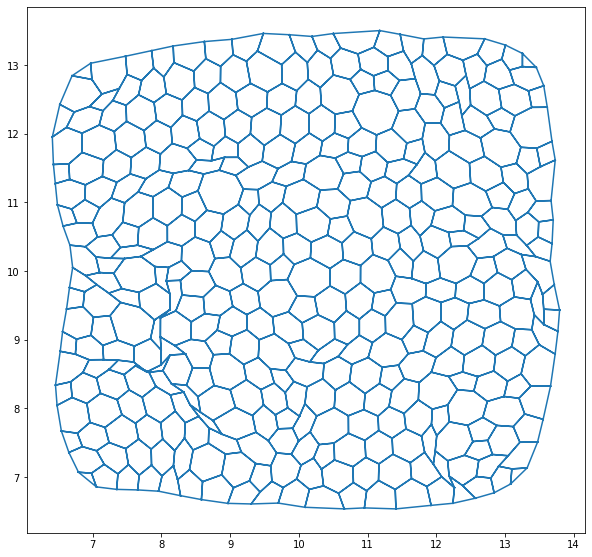

In [10]:
fig, ax = sheet_view(cellmap_E, mode="quick")
fig.set_size_inches(10, 10)

print(cellmap_E.face_df["area"].mean())
#plt.savefig('cellmap_uniform_expansion.png')

## T cell proliferation

In [11]:
#choosing random 10 of Aalphas:

endTime = 10

ten_random_faces = cellmap_E.face_df.sample(10)
current_prefered_area = ten_random_faces["prefered_area"]
print(current_prefered_area)
ten_random_faces["prefered_area"]= 2.5*current_prefered_area
cellmap_E.face_df.loc[ten_random_faces.index, "prefered_area"] = ten_random_faces
geom_E.update_all(cellmap_E)

print(ten_random_faces["prefered_area"])

#geom.update_all(cellmap_E)

new_verts = np.empty((0, 3))
for numEdge in range(len(cellmap_E.edge_df)):
    currentEdge = cellmap_E.edge_df.loc[numEdge];
    if currentEdge['length']>2:
        new_vert = add_vert(cellmap_E, numEdge)
        new_verts = np.append(new_verts, [new_vert])
    solver_T = QSSolver()
    res_T = solver_T.find_energy_min(cellmap_E, geom_E, model_E)

#for i in range(endTime):
#    solver1 = QSSolver(with_collisions=False, with_t1=False, with_t3=False)
#    res1 = solver1.find_energy_min(cellmap_H, geom_H, model_H, options={"ftol": 1e-2})
#    geom_H.update_all(cellmap_H)
#    history_H.record(time_stamp = i)

cellmap_T = cellmap_E
geom_T = geom_E
model_T = model_E
history_T = history_E

face
305    2.458992
9      3.562092
203    1.817292
255    1.131792
127    3.671892
111    2.983392
195    3.076392
165    3.191292
62     3.615192
298    2.363892
Name: prefered_area, dtype: float64
face
305    6.14748
9      8.90523
203    4.54323
255    2.82948
127    9.17973
111    7.45848
195    7.69098
165    7.97823
62     9.03798
298    5.90973
Name: prefered_area, dtype: float64


1.2929586561932762

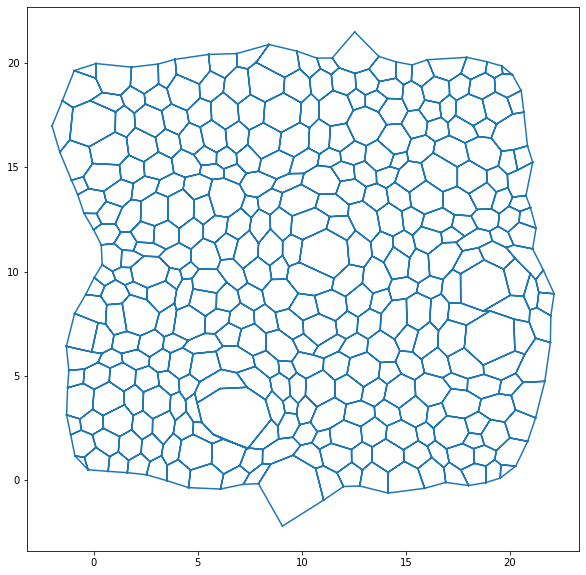

In [12]:
fig, ax = sheet_view(cellmap_T, mode="quick")

fig.set_size_inches(10, 10)
cellmap_T.face_df['area'].mean()
#plt.savefig('cellmap_T_cell_expansion.png')

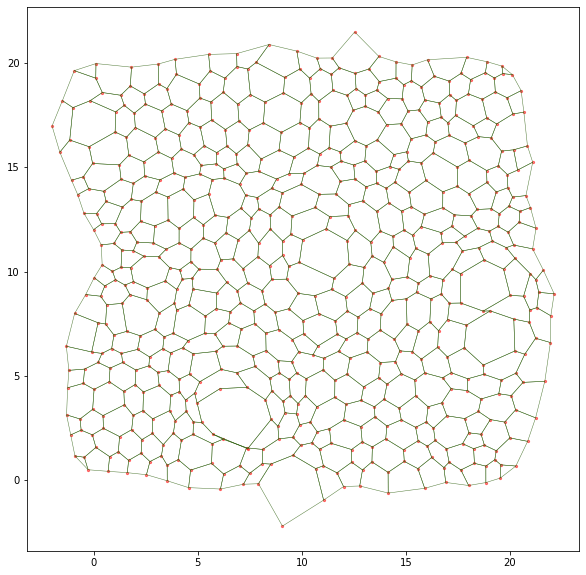

In [13]:
draw_specs = tyssue.config.draw.sheet_spec()

draw_specs['vert']['visible'] = True

draw_specs['vert']['color'] = "red"
draw_specs['vert']['alpha'] = 0.5
draw_specs['vert']['s'] = 5
coords = ['x', 'y']
fig, ax = sheet_view(cellmap_T, coords, **draw_specs)
fig.set_size_inches((10, 10))